In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos

<ErrorbarContainer object of 3 artists>

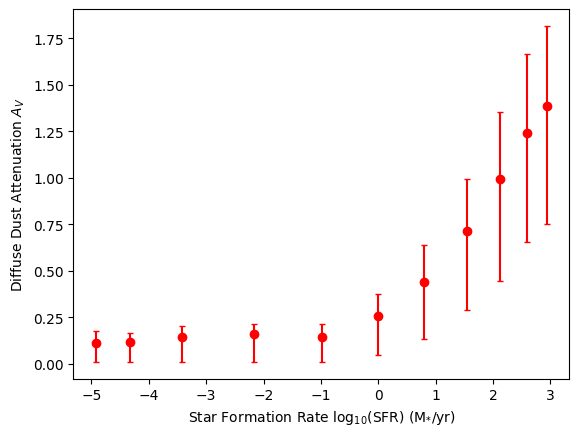

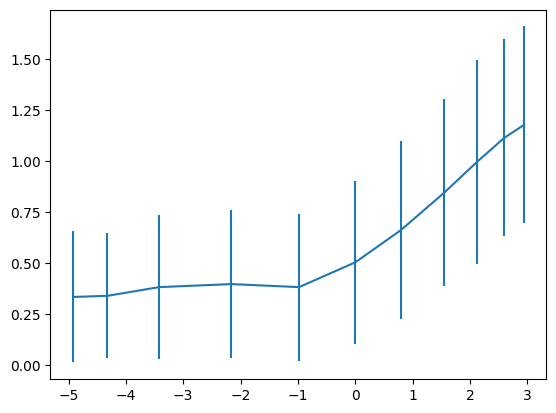

In [2]:
def extract_from_file(file):
    #https://iopscience.iop.org/article/10.3847/1538-4357/aabf3c
    #and popcosmos

    data = ascii.read(file)
    av = np.array(data['x'])
    n = np.array(data['y'])
    n_err_l_val = np.array(data['yl'])
    n_err_h_val = np.array(data['yh'])
    n_err_l = n - n_err_l_val
    n_err_h = n_err_h_val - n
    n_err = n_err_l + n_err_h

    return n, av, n_err, n_err_l, n_err_h

def error_prop(function, x, xerrl, xerrh):

    value = function(x)
    value_errl = value - function(x-xerrl)
    value_errh = function(x+xerrh) - value
    value_err = function(x+xerrh) - function(x-xerrl)

    return value, value_errl, value_errh, value_err

def create_gp_model(lengthscale, errors, train_x, train_y):

    class GPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(GPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])), outputscale_prior=gpytorch.priors.SmoothedBoxPrior(0, 2.0))
            #self.covar_module = gpytorch.kernels.ConstantKernel()+gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(errors), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
    model = GPModel(train_x, train_y, likelihood)

    return model, likelihood


def gp_training_loop(model, likelihood, train_x, train_y, training_iter, lr=1e-4):

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #i + 1, training_iter, loss.item(),
        print(loss.item())
            #model.likelihood.noise.item()
        #))
        optimizer.step()

    return model, likelihood

av_popsfr, sfr_popsfr, av_err_popsfr, av_err_l_popsfr, av_err_h_popsfr = extract_from_file("dust_data/sfr_popcosmos_data.txt")
plt.errorbar(sfr_popsfr, av_popsfr, yerr=[av_err_l_popsfr, av_err_h_popsfr], fmt='ro', capsize=2)
plt.xlabel("Star Formation Rate log$_{10}$(SFR) (M$_{*}$/yr)")
plt.ylabel("Diffuse Dust Attenuation $A_{V}$")


train_sfr = torch.from_numpy(sfr_popsfr)
train_av = torch.from_numpy(av_popsfr)
train_av_err_l = torch.from_numpy(av_err_l_popsfr)
train_av_err_h = torch.from_numpy(av_err_h_popsfr)
train_av_errors = torch.from_numpy(av_err_popsfr)

def func(x):
    return np.sqrt(x)
def invfunc(x):
    return (x)**2.0

log_train_av, log_train_av_errl, log_train_av_errh, log_train_av_errs = error_prop(func, train_av, train_av_err_l, train_av_err_h)

#def norm(x):
#    return (x - np.mean(x.numpy()))/np.std(x.numpy())
#def unnorm(x):
#    return x*np.std(x.numpy())+np.mean(x.numpy())

#log_train_av, log_train_av_errl, log_train_av_errh, log_train_av_errs = error_prop(norm, log_train_av, log_train_av_errl, log_train_av_errh)

f, ax = plt.subplots(1, 1)
ax.errorbar(train_sfr, log_train_av, yerr=log_train_av_errs)

#mean = np.interp(np.linspace(-5, 3, 100), train_sfr, train_av)
#plt.plot(np.linspace(-5, 3, 100), mean)



In [3]:
error_prop(func, 10, 1, 1)

(3.1622776601683795,
 0.16227766016837952,
 0.1543471301870203,
 0.3166247903553998)

In [4]:
model, likelihood = create_gp_model([0.0, 10.0], log_train_av_errs, train_sfr, log_train_av)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [5]:
training_iter = 20000

model, likelihood = gp_training_loop(model, likelihood, train_sfr, log_train_av, training_iter, lr=1e-2)

1.1358708765414531
1.132033729703396
1.128204768992803
1.1243847139879042
1.1205740679246556
1.116773573360011
1.112983893798942
1.1092056685904408
1.105439582394869
1.1016862748735365
1.097946499358769
1.094220921367586
1.0905101815260236
1.0868150566114383
1.0831361597038855
1.079474194174999
1.0758298779884272
1.0722038380198569
1.068596818437413
1.0650093977789163
1.0614423240121083
1.0578961675169678
1.0543716100892129
1.0508692460600095
1.0473897191635904
1.0439335964897432
1.0405014693438819
1.0370938523007263
1.0337113819785373
1.030354504667231
1.0270237374908604
1.023719586859786
1.0204424947744464
1.0171929055202447
1.0139712080608203
1.010777852858643
1.007613158457461
1.0044774779117525
1.0013711359778936
0.9982944405871588
0.9952476586444955
0.9922309661103316
0.9892446856961752
0.9862889741999914
0.9833639643802156
0.9804698415237002
0.9776067217441586
0.9747746901308642
0.9719738313196505
0.969204213149688
0.9664658150669946
0.9637586951814786
0.9610828220752684
0.95843

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(-8, 5, 100)

f_preds = model(test_x)
mean = np.interp(test_x.numpy(), train_sfr.numpy(), train_av.numpy())
#y_preds = likelihood(model(test_x))

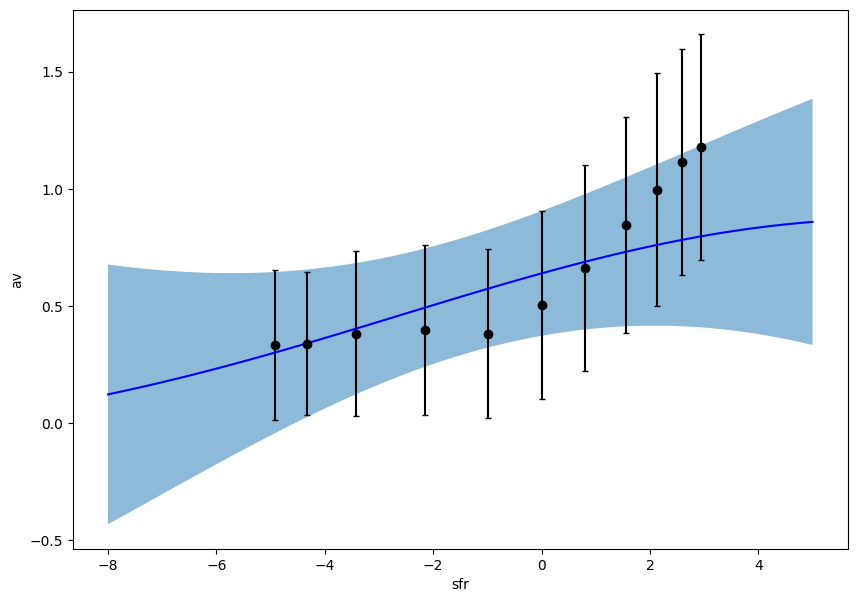

In [7]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_sfr.numpy(), log_train_av, yerr=log_train_av_errs, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("sfr")
    ax.set_ylabel("av")

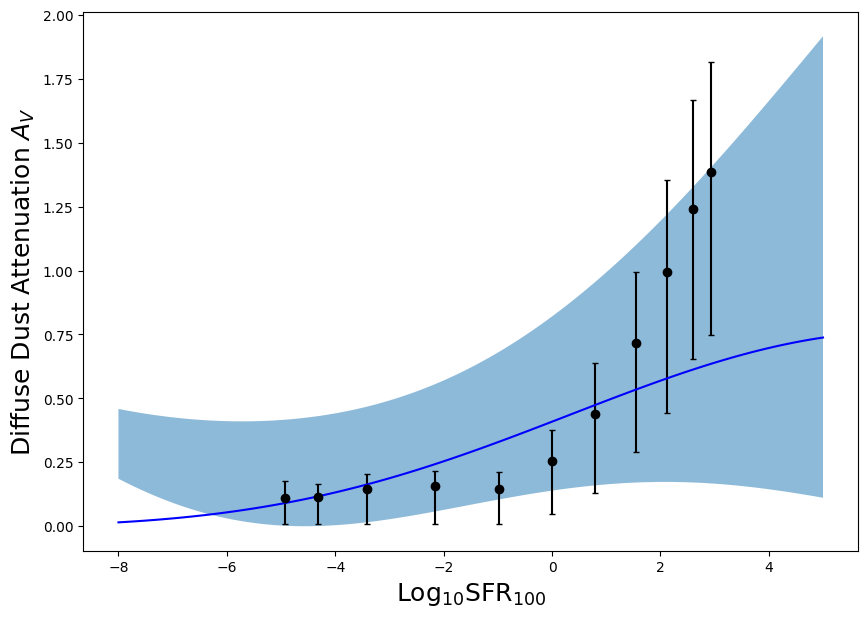

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_sfr.numpy(), train_av, yerr=[train_av_err_l, train_av_err_h], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), invfunc(f_preds.mean), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), invfunc(lower), invfunc(upper), alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("$\mathrm{Log}_{10}\mathrm{SFR}_{100}$", fontsize=18)
    ax.set_ylabel("Diffuse Dust Attenuation $A_{V}$", fontsize=18)

In [9]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = -0.4998123049736023
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 9.835780143737793


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


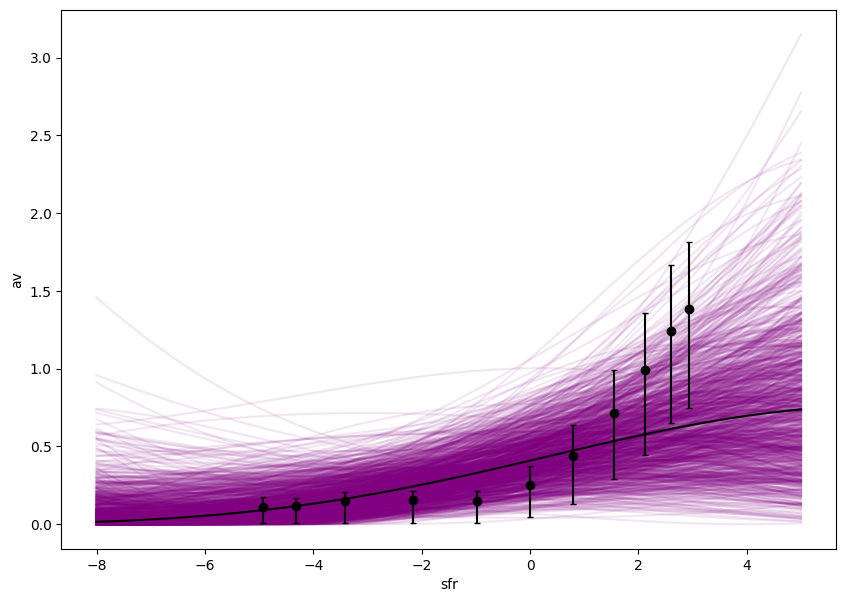

In [10]:
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = invfunc(f_preds.sample())
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample, c='purple', alpha=0.1)
    ax.plot(test_x, invfunc(f_preds.mean), zorder=1000, ls='-', c='k')
    ax.errorbar(train_sfr.numpy(), train_av.numpy(), yerr=[train_av_err_l, train_av_err_h], fmt='ko', capsize=2)
    
    ax.set_xlabel("sfr")
    ax.set_ylabel("av")

In [11]:
#torch.save(model.state_dict(), 'gp_models/gp_dust2.pth')